In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
#from kerashypetune import KerasRandomSearch, KerasGridSearch

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
!pip install yfinance

[*********************100%***********************]  1 of 1 completed


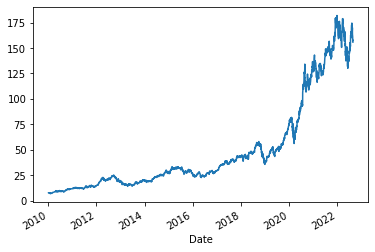

(3190, 6)

In [3]:
# Import the yfinance. If you get module not found error the run !pip install yfiannce from your Jupyter notebook 
import yfinance as yf   
 
# Get the data of the stock AAPL 
aapl_df = yf.download('AAPL','2010-01-01','2022-09-03')

# Plot the close price of the AAPL 
aapl_df.Close.plot()
plt.show() 
aapl_df.shape

In [4]:
del aapl_df['Volume']

In [5]:
 aapl_df.shape

(3190, 5)

In [6]:
aapl_df.head(2)

,Open,High,Low,Close,Adj Close
Date,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.526021
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.537302


[*********************100%***********************]  1 of 1 completed


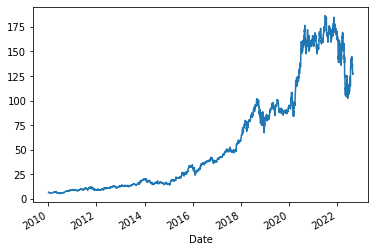

In [7]:
amzn_df = yf.download('AMZN','2010-01-01','2022-09-03')
 
# Plot the close price of the AMZN
amzn_df.Close.plot()
plt.show()

[*********************100%***********************]  1 of 1 completed


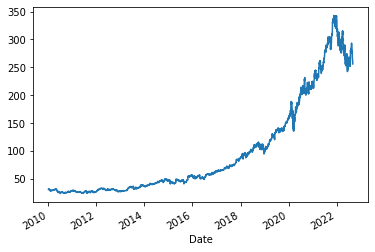

In [8]:
msft_df = yf.download('MSFT','2010-01-01','2022-09-03')
 
# Plot the close price of the Microsoft
msft_df.Close.plot()
plt.show()

In [9]:
filepath = '../input/imbdataset/output-onlinecsvtools.txt'
df = pd.read_csv(filepath)
print(df.shape)  # (123, 8)
df.head(2)

(3020, 6)


,Date,Open,High,Low,Close,Volume
0,2006-01-03,82.45,82.55,80.81,82.06,11715200
1,2006-01-04,82.20,82.50,81.33,81.95,9840600


In [10]:
# df = dff.drop(['Volume'], axis=1)

In [11]:
# aapl_df.set_index('Date', inplace=True)
# aapl_df.info()

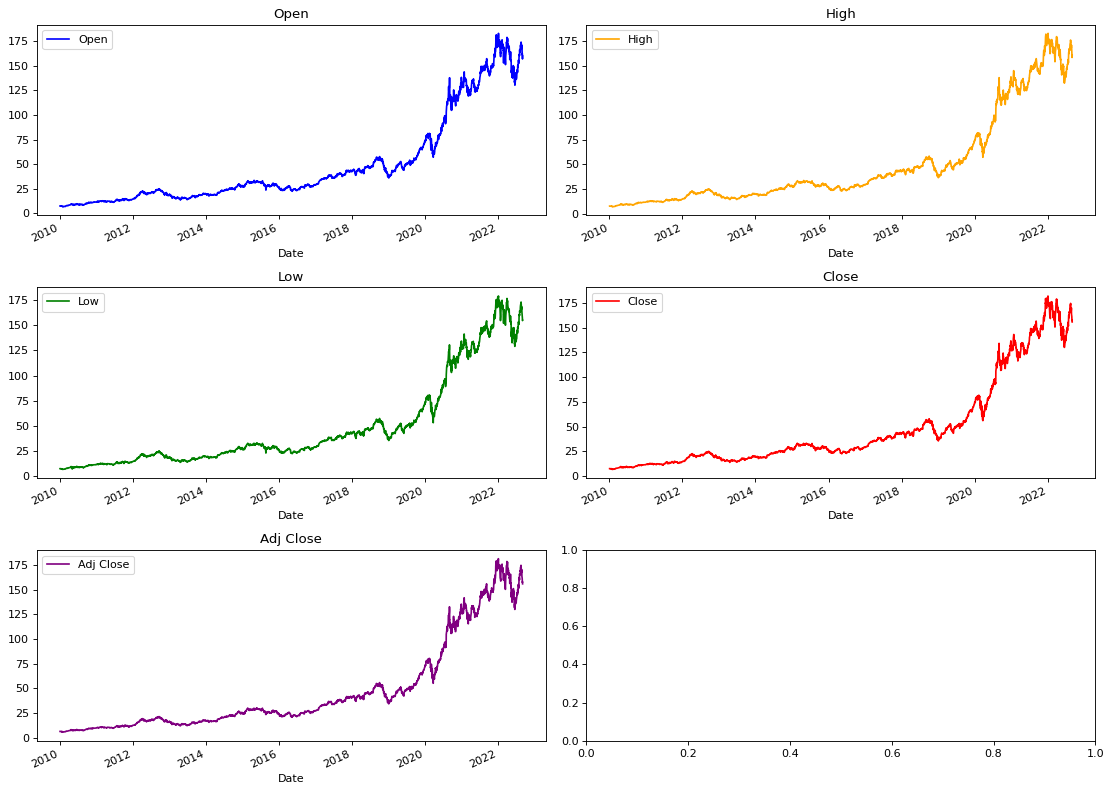

In [12]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

def Visualize(data):
    features= list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(aapl_df)

In [13]:
aapl_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

In [14]:
# # creating series True or False for NaN data and present data respectively. 
# nul_data = pd.isnull(df['Open']) 
    
# # print only the data, Customers = NaN 
# df[nul_data]

In [15]:
# df = df.dropna(axis=1)

In [16]:
# df.isnull().sum()

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(aapl_df, variables = aapl_df.columns) 

,Open_x,High_x,Low_x,Close_x,Adj Close_x
Open_y,1.0,0.0000,0.0,0.000,0.0000
High_y,0.0,1.0000,0.0,0.000,0.0000
Low_y,0.0,0.0000,1.0,0.000,0.0000
Close_y,0.0,0.0002,0.0,1.000,0.0944
Adj Close_y,0.0,0.0001,0.0,0.109,1.0000


In [18]:
nobs = 2500
df_train, df_test = aapl_df[0:-nobs], aapl_df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(690, 5)
(2500, 5)


In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [20]:
 from statsmodels.tsa.stattools import adfuller

In [21]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.6707
 No. Lags Chosen       = 11
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.9892. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.796
 No. Lags Chosen       = 7
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.9916. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [22]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [23]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7921
 No. Lags Chosen       = 18
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9492
 No. Lags Chosen       = 6
 Critical value 1%     = -3.44
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

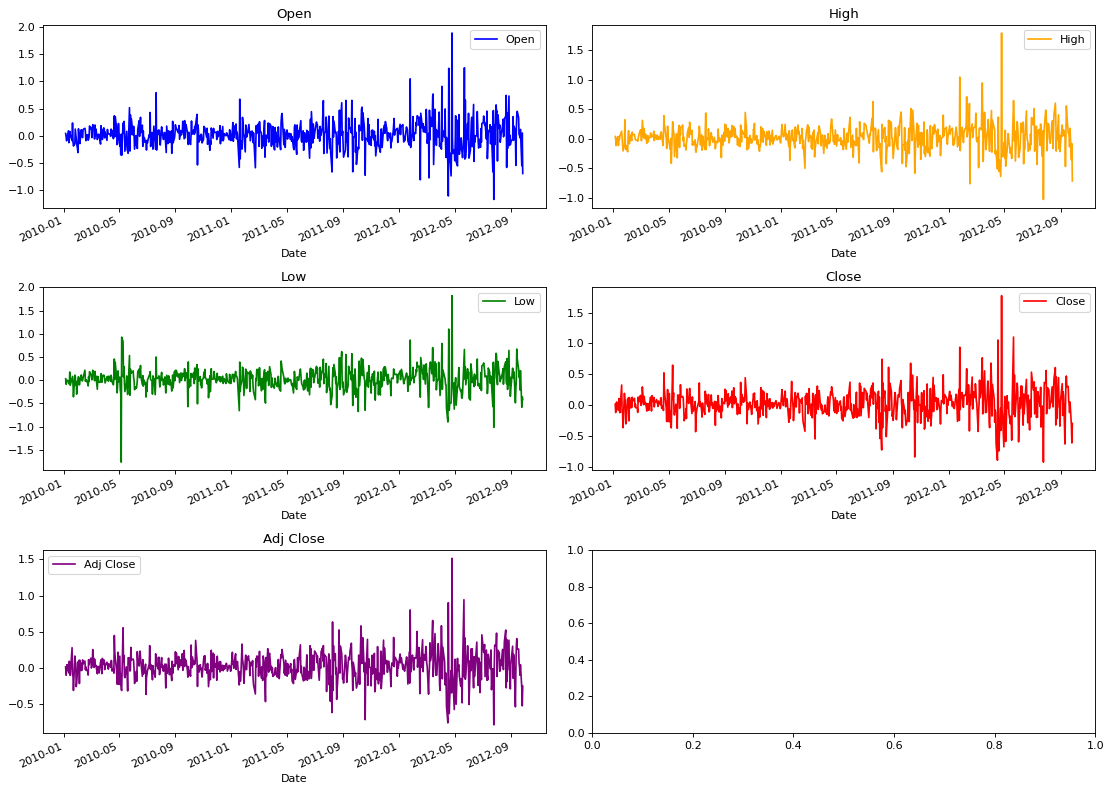

In [24]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

def Visualize(data):
    features= list(data.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(df_differenced)

In [25]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -27.252909648117218
BIC :  -27.05521536739338
FPE :  1.4595288509374332e-12
HQIC:  -27.176428224114613 

Lag Order = 2
AIC :  -27.606249126384668
BIC :  -27.243398491636153
FPE :  1.0250953932187928e-12
HQIC:  -27.4658647324164 

Lag Order = 3
AIC :  -27.823645714697967
BIC :  -27.29526348405938
FPE :  8.248264386540435e-13
HQIC:  -27.619204587327 

Lag Order = 4
AIC :  -27.856544692135294
BIC :  -27.16225421327758
FPE :  7.981749426436744e-13
HQIC:  -27.58789247677102 

Lag Order = 5
AIC :  -27.9207173307389
BIC :  -27.060140533529935
FPE :  7.48628075412505e-13
HQIC:  -27.58769907852898 

Lag Order = 6
AIC :  -27.981376001049732
BIC :  -26.95413339016617
FPE :  7.046579124558627e-13
HQIC:  -27.583836165751215 

Lag Order = 7
AIC :  -28.036166475530138
BIC :  -26.841877123020133
FPE :  6.672074440769722e-13
HQIC:  -27.57394891035969 

Lag Order = 8
AIC :  -28.0636193134678
BIC :  -26.701900851264206
FPE :  6.49294308475609e-13
HQIC:  -27.53656726793089 

Lag Order

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
x = model.select_order(maxlags=11)
x.summary()

,AIC,BIC,FPE,HQIC
0,-26.10,-26.07,4.615e-12,-26.09
1,-27.19,-26.99,1.549e-12,-27.12
2,-27.55,-27.18,1.083e-12,-27.41
3,-27.78,-27.24*,8.659e-13,-27.57*
4,-27.81,-27.11,8.324e-13,-27.54
5,-27.88,-27.02,7.759e-13,-27.55
6,-27.95,-26.92,7.257e-13,-27.55
7,-28.01,-26.81,6.831e-13,-27.55
8,-28.05,-26.68,6.599e-13,-27.52
9,-28.07,-26.54,6.438e-13,-27.48


In [27]:
from tqdm import tqdm

In [28]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(0,12)):
    model = VAR(endog=df_differenced.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 12/12 [00:00<00:00, 158.32it/s]

BEST ORDER: 11 BEST AIC: -28.096556546650028


In [29]:
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 05, Sep, 2022
Time:                     11:35:07
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -26.2302
Nobs:                     678.000    HQIC:                  -27.3741
Log likelihood:           4994.53    FPE:                6.28984e-13
AIC:                     -28.0966    Det(Omega_mle):     4.22968e-13
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.010760         0.006694            1.607           0.108
L1.y1         -1.167306         0.076987          -15.162           0.000
L1.y2          0.126588         0.098933            1.280           0.201
L1.y3          0.

In [30]:
model_fitted.aic

-28.096556546650028

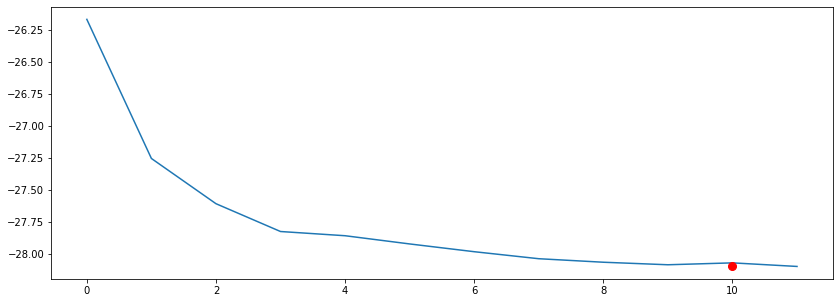

In [31]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
# plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
# plt.xlabel('lags'); plt.ylabel('AIC')
# np.set_printoptions(False)

# COMBINE VAR AND LSTM

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [33]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(aapl_df, shuffle=False, train_size=0.8)


print(train.shape, test.shape)

(2552, 5) (638, 5)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [35]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):
    
    set_seed(33)
    
    opt = Adam()
    opt.lr = param['lr']
        
    inp = Input(shape=(look_back, 5))
    
    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', 
             return_sequences=True)(x)
    out = TimeDistributed(Dense(5))(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, kgs, look_ahead, look_back):
    
    set_seed(33)
    
    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())
    
    best_model_config.optimizer.lr = param['lr']
    
    return best_model_config

In [36]:
print(best_order)

11


In [37]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = model_fitted.fittedvalues


X_train = train.iloc[best_order:].values
X_train_var = model_fitted.fittedvalues

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = test.values

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(2032, 5) (509, 5) (638, 5)
(542, 5) (136, 5)
(2032, 5) (509, 5) (638, 5)
(542, 5) (136, 5)


In [38]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [39]:
### BUILD DATA GENERATOR ###

look_back = 60
look_ahead = 5

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)

X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(1968, 60, 5) (445, 60, 5) (574, 60, 5)
(478, 60, 5) (72, 60, 5)
(1968, 5, 5) (445, 5, 5) (574, 5, 5)
(478, 5, 5) (72, 5, 5)


In [40]:
!pip install --upgrade keras-hypetune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.0/966.0 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.2.7
    Uninstalling hyperopt-0.2.7:
      Successfully uninstalled hyperopt-0.2.7


In [41]:
from kerashypetune import KerasRandomSearch, KerasGridSearch

In [42]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [128, 96, 64], 
    'lr': [7e-4, 1e-3, 3e-3], 
    'epochs': 200, 
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025), 
    'epochs': 200, 
}

In [43]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs_var = KerasGridSearch(hypermodel, param_grid, 
                          monitor='val_loss')
kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')


2022-09-05 11:35:19.520100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:35:19.654307: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:35:19.655751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 11:35:19.662200: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil


***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})


2022-09-05 11:35:22.750712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-05 11:35:25.859111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


SCORE: 2.98668 at epoch 1

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.98668 at epoch 1

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 2.99329 at epoch 1

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.99329 at epoch 1

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 2.98699 at epoch 1

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.98699 at epoch 1

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 2.99024 at epoch 2

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.99024 at epoch 2

***** (9/18) *****
Search({'units_lstm': 64, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 2.9907 at epoch 1

**

In [44]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'], 
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 1.4109 at epoch 186

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 1.38018 at epoch 123

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 2.30442 at epoch 199

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 0.92837 at epoch 78

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 0.52118 at epoch 140

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 2.32021 at epoch 199

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 0.94299 at epoch 115

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 3.61986 at epoch 200

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 2.94755 at epoch 200

***** (10/20) *****
Search({'lr': 9.77297705045092

In [45]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

In [46]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs = KerasGridSearch(hypermodel, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 2.98668 at epoch 1

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.98668 at epoch 1

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 2.99329 at epoch 1

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.99329 at epoch 1

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 2.98699 at epoch 1

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 2.98699 at epoch 1

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 2.99024 at epoch 2

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'bat

In [47]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

In [48]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(aapl_df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = np.sqrt(error)

In [49]:
print(error_lstm.values() , "\n")
print(error_var_lstm.values(), "\n")
print(error_baseline.values())

dict_values([117.50842633538612, 120.38433184524374, 118.73607991764275, 122.15619198718028, 117.28450478130871]) 

dict_values([78.65816292574053, 80.63620593623982, 76.69691871644645, 78.06524167161459, 81.63172357579164]) 

dict_values([4.722776535607616, 4.3856076192633004, 4.509967882686952, 4.583224938352782, 4.553726884218536])


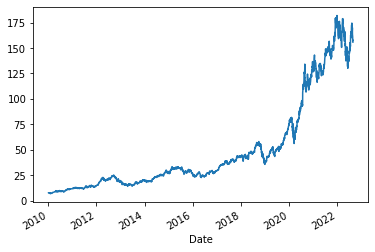

(3190, 5)

In [50]:
#Plot the close price of the AAPL 

aapl_df.Close.plot()
plt.show() 
aapl_df.shape

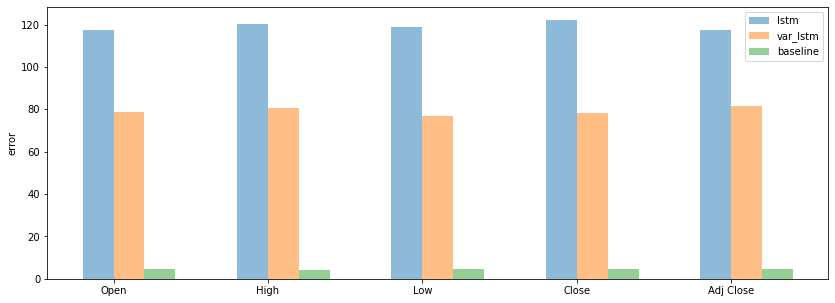

In [51]:
### COMPARE RESULTS ###

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm))-0.1, error_lstm.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm))+0.1, error_var_lstm.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
plt.bar(np.arange(len(error_baseline))+0.3, error_baseline.values(), 
        alpha=0.5, width=0.2, label='baseline')

plt.xticks(range(len(error_lstm)), error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)

In [52]:
print(error_var_lstm )
print("\n")
print(error_lstm)

{'Open': 78.65816292574053, 'High': 80.63620593623982, 'Low': 76.69691871644645, 'Close': 78.06524167161459, 'Adj Close': 81.63172357579164}


{'Open': 117.50842633538612, 'High': 120.38433184524374, 'Low': 118.73607991764275, 'Close': 122.15619198718028, 'Adj Close': 117.28450478130871}


In [53]:
print(error_lstm.values() , "\n")
print(error_var_lstm.values(), "\n")
print(error_baseline.values())

dict_values([117.50842633538612, 120.38433184524374, 118.73607991764275, 122.15619198718028, 117.28450478130871]) 

dict_values([78.65816292574053, 80.63620593623982, 76.69691871644645, 78.06524167161459, 81.63172357579164]) 

dict_values([4.722776535607616, 4.3856076192633004, 4.509967882686952, 4.583224938352782, 4.553726884218536])


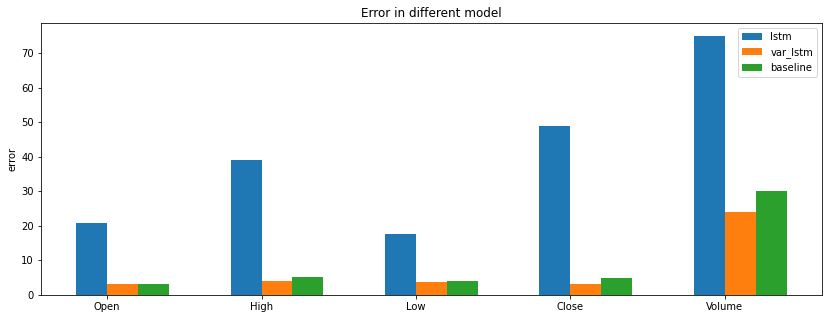

In [54]:
plt.figure(figsize=(14,5))

import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Open','High','Low','Close','Volume']
error_lstm = [20.66492418671569, 38.974809879545674, 17.681488543866916, 49.0045191790099, 75]
erro_lstm_var = [3.232760628935787, 4.005440009023976, 3.697889901080616, 3.1827831325548504, 24]
error_baseline = [3.1890914663981206, 5.123259733617484, 4.135976209711864, 4.995570698781219, 30]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.1, error_lstm, 0.2, label = 'lstm')
plt.bar(X_axis + 0.1, erro_lstm_var, 0.2, label = 'var_lstm')
plt.bar(X_axis + 0.3, error_baseline, 0.2, label = 'baseline')
  
plt.xticks(X_axis, X)
# plt.xlabel("Groups")
plt.ylabel("error")
plt.title("Error in different model")
plt.legend()
plt.show()